# Continuous Control Project

I'll begin this project by implementing a straight DDPG solution and see how that works.  Depending on the amount of time it takes, I hope to follow up with additional layers of sophistication.

-----

## Solution 1 - Simple DDPG

The code below is based on the Udacity instructor-provided code from the financial markets lesson.  I have modified it somewhat to adapt to the robot arm problem for this project.

### Set up the Unity reacher environment for a single arm

In [1]:
!pip -q install ./python
print("Python install done.")

from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='Reacher_Linux/Reacher.x86_64')
print("Environment defined.")

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print(brain)

ERROR: Could not find a version that satisfies the requirement tensorflow==1.7.1 (from unityagents==0.4.0) (from versions: 2.2.0rc1, 2.2.0rc2, 2.2.0rc3, 2.2.0rc4, 2.2.0, 2.2.1, 2.2.2, 2.3.0rc0, 2.3.0rc1, 2.3.0rc2, 2.3.0, 2.3.1, 2.3.2, 2.4.0rc0, 2.4.0rc1, 2.4.0rc2, 2.4.0rc3, 2.4.0rc4, 2.4.0, 2.4.1)
ERROR: No matching distribution found for tensorflow==1.7.1 (from unityagents==0.4.0)
Python install done.


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environment defined.
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [2]:
##### Set up the environment

import time
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from ddpg_agent import DdpgAgent

%matplotlib inline


In [3]:
WINNING_SCORE = 30.0 #average over 100 consecutive episodes

def train(agent, env, max_episodes=20, max_time_steps=100, break_in=32, sleeping=False):

    # Initialize simulation environment
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    env_info = env.reset(train_mode=True)[brain_name]
    state_size = len(env_info.vector_observations[0])
    action_size = brain.vector_action_space_size

    scores = []
    recent_scores = deque(maxlen=100)

    # loop on episodes
    for e in range(max_episodes):
        
        # Reset the enviroment
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0 #total score for this episode

        # loop over time steps
        for i in range(max_time_steps):

            # Predict the best action for the current state.
            action = agent.act(state)

            # get the new state & reward based on this action
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]

            # update the agent with this new info
            agent.step(state, action, reward, next_state, done)

            # roll over new state
            state = next_state
            score += reward
            if done:
                break

        # update score bookkeeping, report status and decide if training is complete
        scores.append(score)
        recent_scores.append(score)
        avg_score = np.mean(recent_scores)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(e, avg_score), end="")
        if e > 0  and  e % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(e, avg_score))

        if sleeping:
            if e > break_in  and  e % 1000 < 50:
                time.sleep(1) #allow time to view the Unity window

        if e % 1000 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpointa_{}.pt'.format(e))
            torch.save(agent.critic_local.state_dict(), 'checkpointc_{}.pt'.format(e))
            
        if avg_score >= WINNING_SCORE:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e, avg_score))
            torch.save(agent.actor_local.state_dict(), 'checkpointa.pt')
            torch.save(agent.critic_local.state_dict(), 'checkpointc.pt')
            break

    return scores

Episode 100	Average Score: 0.05
Episode 200	Average Score: 0.04
Episode 300	Average Score: 0.04
Episode 400	Average Score: 0.04
Episode 500	Average Score: 0.09
Episode 600	Average Score: 0.21
Episode 700	Average Score: 0.21
Episode 800	Average Score: 0.21
Episode 900	Average Score: 0.22
Episode 1000	Average Score: 0.26
Episode 1100	Average Score: 0.19
Episode 1200	Average Score: 0.22
Episode 1300	Average Score: 0.24
Episode 1400	Average Score: 0.24
Episode 1500	Average Score: 0.23
Episode 1600	Average Score: 0.24
Episode 1700	Average Score: 0.21
Episode 1800	Average Score: 0.25
Episode 1900	Average Score: 0.25
Episode 2000	Average Score: 0.23
Episode 2100	Average Score: 0.22
Episode 2200	Average Score: 0.26
Episode 2300	Average Score: 0.23
Episode 2400	Average Score: 0.25
Episode 2500	Average Score: 0.23
Episode 2600	Average Score: 0.26
Episode 2700	Average Score: 0.22
Episode 2800	Average Score: 0.25
Episode 2900	Average Score: 0.21
Episode 2999	Average Score: 0.22

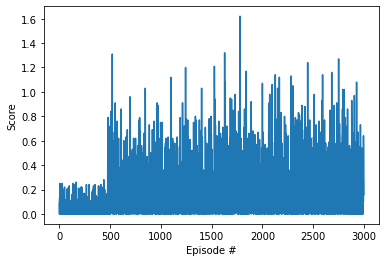

In [4]:
## Train the model & observe its progress

BATCH = 32
a = DdpgAgent(33, 4, random_seed=0, batch_size=BATCH)

scores = train(a, env, max_episodes=3000, max_time_steps=400, break_in=BATCH, sleeping=True)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


In [5]:
env.close()